# TSC for Fault Detection of CAN data

## Prelims

In [2]:
import os 
import sys
import numpy as np
from collections import defaultdict
import glob
from tqdm import tqdm
import itertools
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, spearmanr
from sklearn.preprocessing import normalize, scale, MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


work_path = os.path.join(os.path.join(os.path.expanduser("~"), "fault-data-analysis"))
os.chdir(work_path)
sys.path.insert(0, "src") # add src folder to path so that files from this folder can be imported
import CAN_objects.aid_message
from generalFunctions import unpickle
import subprocess

import importlib
importlib.reload(CAN_objects.aid_message)
import json
import seaborn as sns
import pandas as pd
from CAN_objects.capture import MappedCapture, MatchedCapture
import math
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram, linkage, fcluster
from pprint import pprint
from sklearn.metrics.cluster import normalized_mutual_info_score

import signal_based_preprocess_functions

ModuleNotFoundError: No module named 'CAN_objects'

## Visualization and Feature Extraction

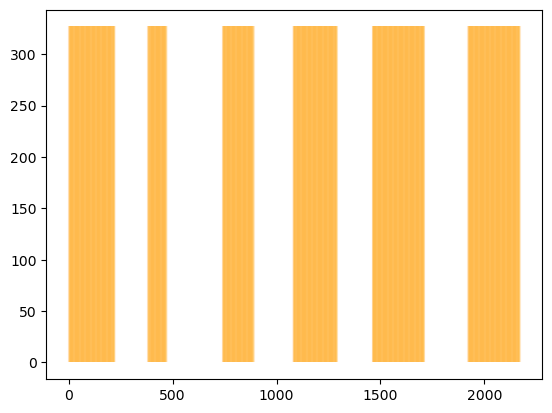

In [11]:
df = pd.DataFrame(aligned_data.iloc[:-1,:])
ymin = min(df.columns[:-2])
ymax = max(df.columns[:-2])

# Plot Fault Status as vertical lines (assuming 1 represents a fault)
fault_indices = df[df['Fault_Status'] == 1].index
plt.vlines(fault_indices, ymin=ymin, ymax=ymax, color='orange', alpha=0.1, label='Fault Status')

In [15]:
# Create a DataFrame from the aligned data
df = pd.DataFrame(aligned_data.iloc[:-1, :])

# Initialize variables to track fault lengths
fault_lengths = []
current_length = 0

# Iterate through the 'Fault_Status' column
for i, status in enumerate(df['Fault_Status']):
    if status == 1:
        current_length += 1
    elif current_length > 0:
        # End of a fault zone
        fault_lengths.append(current_length)
        current_length = 0

# Append the last fault zone if the data ends with a fault
if current_length > 0:
    fault_lengths.append(current_length)

# Print the fault lengths
print("Fault zone lengths (in time steps):", fault_lengths)

Fault zone lengths (in time steps): [221, 90, 150, 211, 250, 250]


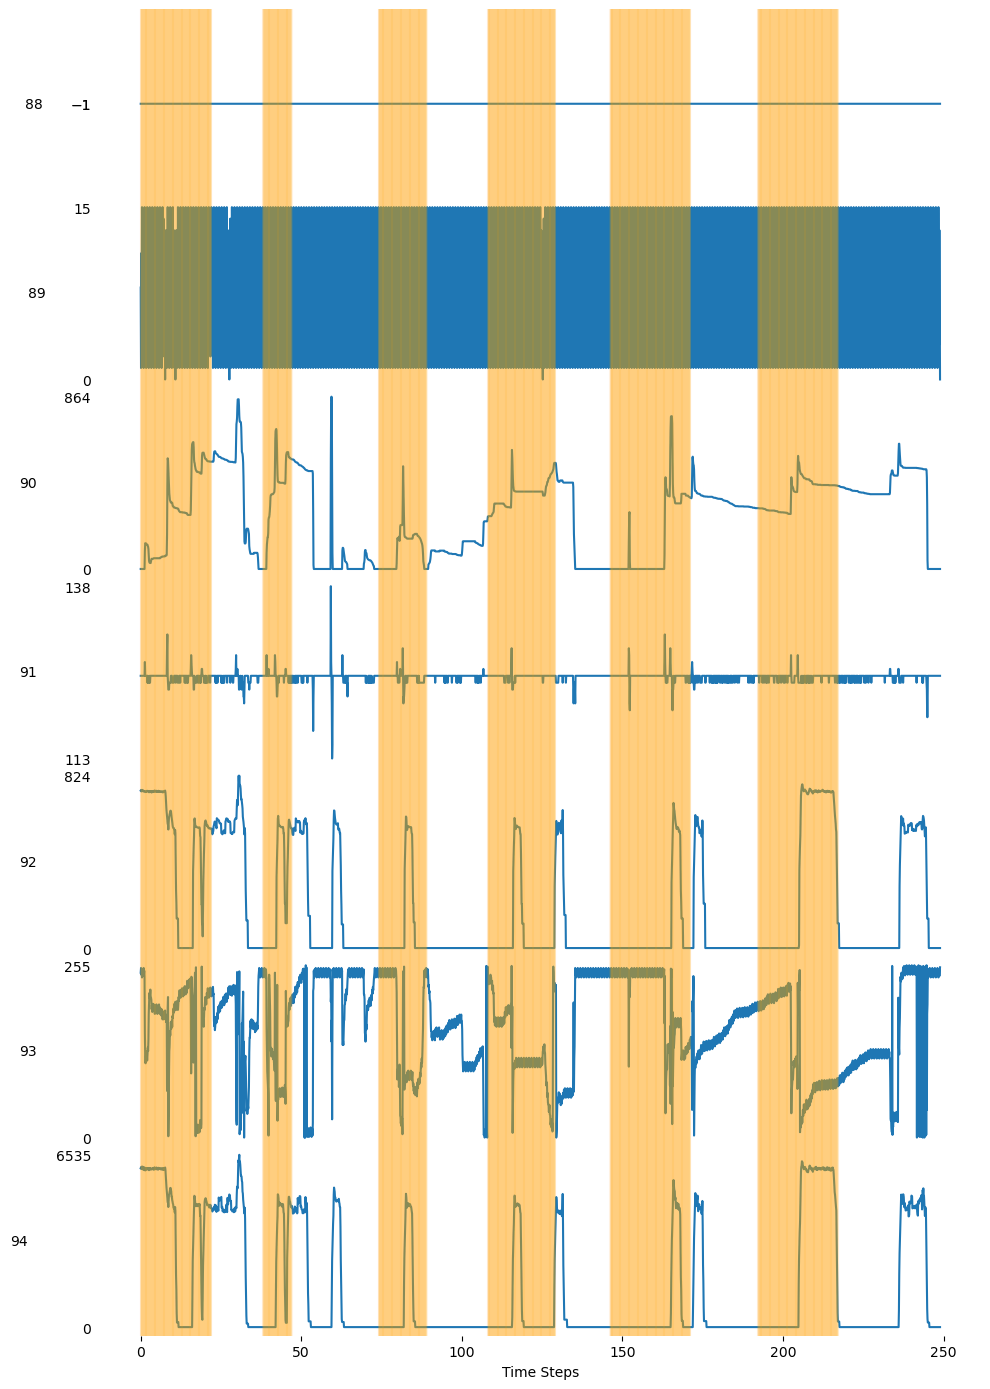

In [14]:
# Data organization with fault overlay:
can_data = aligned_data
feature_ids = can_data.iloc[-1, :-2]  # Excluding 'Time' and 'Fault_Status'
can_data_cleaned = can_data.iloc[:-1, :-2]  # Excluding the ID row and last two columns
can_data_cleaned['Time'] = can_data['Time'][:-1]  # Copy the 'Time' column except for the last value
can_data_cleaned['Fault_Status'] = can_data['Fault_Status'][:-1]  # Copy the 'Fault_Status' column except for the last value

id_516 = [col for col, id_ in feature_ids.items() if id_ == 516]

# Determine number of subplots needed
n_features = len(id_516)
fig, axs = plt.subplots(n_features, 1, sharex=True, figsize=(10, 2 * n_features), gridspec_kw={'hspace': 0})

# Ensure 'axs' is an array
axs = np.atleast_1d(axs)

for i, feature in enumerate(id_516):
    axs[i].plot(can_data_cleaned['Time'], can_data_cleaned[feature])
    axs[i].set_ylabel(feature, rotation=0, labelpad=20, verticalalignment='center', horizontalalignment='right')

    # Custom y-ticks 
    axs[i].set_yticks([can_data_cleaned[feature].min(), can_data_cleaned[feature].max()])

    # Remove borders and ticks on the x-axis
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set_visible(False)  # Also remove the left spine
    axs[i].tick_params(left=False)  # Hide left ticks
    
    # Remove the white lines by setting the edge color to 'none'
    for spine in axs[i].spines.values():
        spine.set_edgecolor('none')

# Draw fault status lines across all subplots
fault_times = can_data_cleaned[can_data_cleaned['Fault_Status'] == 1]['Time']
for ax in axs:
    for time in fault_times:
        ax.axvline(x=time, color='orange', alpha=0.1)

axs[-1].set_xlabel('Time Steps')
plt.tight_layout()
plt.savefig()
plt.show()

In [ ]:
import seaborn as sns
 # Create a pivot table to count data points by Fault status
pivot_table = df.pivot_table(index='Fault_Status', aggfunc='size').reset_index(name='Count')

# Create a bar plot to compare data points with and without faults
plt.figure(figsize=(8, 6))
sns.barplot(data=pivot_table, x='Fault_Status', y='Count', palette='viridis')
plt.title('Number of Data Points with and without Faults')
plt.xlabel('Fault Status')
plt.xticks([0, 1], ['No Fault', 'Fault'])
plt.ylabel('Count')

# Show the plot
plt.show()

## TSC Methods

In [15]:
# Packages
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dense, add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, concatenate, GlobalAveragePooling1D, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN  
from tensorflow.keras.callbacks import EarlyStopping  
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, concatenate, GlobalAveragePooling1D, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import matthews_corrcoef

from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import cross_val_score
from scipy import stats
import timeit
import numpy as np
from pandas import read_csv
import seaborn as sns

import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, silhouette_score 
from sklearn import datasets
from sklearn.model_selection import train_test_split
import h5py
from tensorflow import keras
import keras.backend as K
from IPython.display import Image

In [17]:
# Holdout method for time series stream

predictor_columns = df.columns[:-2]
# Convert DataFrame to NumPy arrays before splitting
X = df[predictor_columns].to_numpy()  # Convert predictor columns to NumPy
y = df['Fault_Status'].to_numpy()     # Convert target column to NumPy

# Perform Holdout Split
train_size = 0.9  # 70% for training
split_index = int(len(X) * train_size)

# Sequential train-test split
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training set and transform
X_test = scaler.transform(X_test)        # Transform test set

# Reshape if needed for models like CNN/RNN
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Verify the split
print("Training Set Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print("Testing Set Shapes:")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Class distribution check
print("\nClass Distribution:")
print(f"Training set:\n{np.unique(y_train, return_counts=True)}")
print(f"Testing set:\n{np.unique(y_test, return_counts=True)}")

Training Set Shapes:
X_train: (2241, 328), y_train: (2241,)
Testing Set Shapes:
X_test: (249, 328), y_test: (249,)

Class Distribution:
Training set:
(array([0, 1]), array([1069, 1172]))
Testing set:
(array([0]), array([249]))


### TSC 1- XGBoost

In [18]:
def run_xgboost_and_update_results(X_train, X_test, y_train, y_test):
    # Initialize the model
    model = xgb.XGBClassifier(objective="binary:logistic")
    start_train_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_train_time

    # Make predictions and measure prediction time
    start_pred_time = time.time()
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predicted probabilities
    y_pred = model.predict(X_test)  # Predicted class labels
    prediction_time = time.time() - start_pred_time
        
    # Evaluate the model using accuracy, precision, recall, F1 score, and log loss
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print evaluation metrics
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")

    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

### TSC 2- Random Forest

In [19]:
def run_rf_and_update_results(X_train, X_test, y_train, y_test):
    # Initialize the model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    start_train_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_train_time

    # Make predictions and measure prediction time
    start_pred_time = time.time()
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates
    y_pred = model.predict(X_test)  # Class predictions
    prediction_time = time.time() - start_pred_time

    # Evaluate the model using metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print evaluation metrics
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")
      
    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

### TSC 3- Support Vector Machine

In [20]:
def run_svm_and_update_results(X_train, X_test, y_train, y_test):

    # Create and train the SVM model
    svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
    start_train_time = time.time()
    svm_classifier.fit(X_train, y_train)
    training_time = time.time() - start_train_time
    
    # Make predictions and measure prediction time
    start_pred_time = time.time()
    y_pred = svm_classifier.predict(X_test)
    y_pred_proba = svm_classifier.predict_proba(X_test)[:, 1]
    prediction_time = time.time() - start_pred_time
    
    # Evaluate the model using accuracy, precision, recall, F1 score, and log loss
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")
    
    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

### TSC 4- ROCKET

In [21]:
def convert_to_nested_df(X):

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert scaled data back to DataFrame for ease of processing
    X_scaled = pd.DataFrame(X_scaled)
    
    # Create nested DataFrame format
    nested_df = pd.DataFrame({'series': [pd.Series(X_scaled.iloc[i, :]) for i in range(X_scaled.shape[0])]})
    return nested_df


def run_rocket_and_update_results(X_train, X_test, y_train, y_test):

    # Convert train and test data to nested format
    nested_X_train = convert_to_nested_df(X_train)
    nested_X_test = convert_to_nested_df(X_test)
    
    # Initialize and transform data with ROCKET
    rocket = Rocket(random_state=42)
    rocket.fit(nested_X_train)
    X_train_transform = rocket.transform(nested_X_train)
    X_test_transform = rocket.transform(nested_X_test)

    # Train classifier
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(X_train_transform, y_train)

    # Predict and compute the decision function values
    y_pred_proba = classifier.decision_function(X_test_transform)

    # Predict
    start_pred_time = time.time()
    y_pred = classifier.predict(X_test_transform)
    prediction_time = time.time() - start_pred_time

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")

    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

### TSC 5- LSTM+FCN Hybrid

In [22]:
def make_lstm_fcn_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM part
    lstm_out = LSTM(64, return_sequences=True)(input_layer)
    lstm_out = BatchNormalization()(lstm_out)

    # FCN part
    conv1 = Conv1D(filters=64, kernel_size=8, padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    
    conv2 = Conv1D(filters=64, kernel_size=5, padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    
    conv3 = Conv1D(filters=64, kernel_size=3, padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    
    # Combining LSTM and FCN parts
    x = concatenate([lstm_out, conv3])
    x = GlobalAveragePooling1D()(x)
    
    output_layer = Dense(1, activation='sigmoid')(x)  
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])  
    
    return model

def run_lstm_fcn_and_update_results(X_train, y_train, X_test, y_test):
    # Ensure X_train and X_test have the correct shape
    if X_train.ndim == 2:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    if X_test.ndim == 2:
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define and compile the model for binary classification
    model = make_lstm_fcn_model(input_shape=X_train.shape[1:])

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ModelCheckpoint('lstm_fcn_model.h5', save_best_only=True, monitor='val_loss')
    ]
    
    # Train the model
    start_train_time = time.time()
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=callbacks)
    training_time = time.time() - start_train_time
    
    # Make predictions
    start_pred_time = time.time()
    y_pred_proba = model.predict(X_test).flatten()  # Ensure y_pred_proba is a 1D array for binary classification
    y_pred = (y_pred_proba >= 0.5).astype(int)
    prediction_time = time.time() - start_pred_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")

    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

### TSC 6- InceptionTime

In [23]:
def inception_block(input_tensor, filters):
    conv1 = Conv1D(filters=filters[0], kernel_size=1, activation='relu', padding='same')(input_tensor)
    conv3 = Conv1D(filters=filters[1], kernel_size=3, activation='relu', padding='same')(input_tensor)
    conv5 = Conv1D(filters=filters[2], kernel_size=5, activation='relu', padding='same')(input_tensor)
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool_proj = Conv1D(filters=filters[3], kernel_size=1, activation='relu', padding='same')(pool)
    return concatenate([conv1, conv3, conv5, pool_proj], axis=-1)

def build_inception_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, 7, strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    x = inception_block(x, [64, 128, 32, 32])
    x = inception_block(x, [128, 192, 96, 64])
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1, activation='sigmoid')(x)  # Changed for binary classification
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Changed for binary classification
    return model

def run_inceptiontime_and_update_results(X_train, y_train, X_test, y_test):
    # Ensure input data has the correct shape
    if X_train.ndim == 2:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    if X_test.ndim == 2:
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = build_inception_model(X_train.shape[1:])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ModelCheckpoint('inceptiontime_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
    ]

    start_train_time = time.time()
    history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=callbacks)
    training_time = time.time() - start_train_time

    start_pred_time = time.time()
    y_pred_proba = model.predict(X_test).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    prediction_time = time.time() - start_pred_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")

    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

### TSC 7- ResNet

In [24]:
def build_resnet(input_shape, nb_classes):
    n_feature_maps = 64

    input_layer = Input(shape=input_shape)

    # BLOCK 1
    conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)

    conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)

    conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)

    shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = BatchNormalization()(shortcut_y)

    output_block_1 = add([shortcut_y, conv_z])
    output_block_1 = Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    gap_layer = GlobalAveragePooling1D()(output_block_1)

    output_layer = Dense(nb_classes, activation='sigmoid')(gap_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),
                  metrics=['accuracy'])

    return model

def run_resnet_and_update_results(X_train, y_train, X_test, y_test):
    # Ensure input shape compatibility
    if X_train.ndim == 2:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    if X_test.ndim == 2:
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build and compile the ResNet model for binary classification
    model = build_resnet(input_shape=X_train.shape[1:], nb_classes=1)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    start_train_time = time.time()
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2,
                        verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
    training_time = time.time() - start_train_time

    # Make predictions
    start_pred_time = time.time()
    y_pred_proba = model.predict(X_test).flatten()  # Use flatten() to ensure y_pred_proba is a 1D array
    y_pred = (y_pred_proba >= 0.5).astype(int)
    prediction_time = time.time() - start_pred_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")

    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

### TSC 8- Temporal Convolutional Network

In [25]:
def run_tcn_and_update_results(X_train, y_train, X_test, y_test):
    if X_train.ndim == 2:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    if X_test.ndim == 2:
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential([
        TCN(input_shape=X_train.shape[1:], nb_filters=64, kernel_size=3, dilations=[1, 2, 4], padding='causal', use_skip_connections=True),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    start_train_time = time.time()
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
    training_time = time.time() - start_train_time

    start_pred_time = time.time()
    y_pred_proba = model.predict(X_test).flatten()  
    y_pred = (y_pred_proba >= 0.5).astype(int)
    prediction_time = time.time() - start_pred_time

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    log_loss_value = log_loss(y_test, y_pred_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.4f} seconds")
    print(f"Test accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(f"MCC: {mcc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Log Loss: {log_loss_value:.4f}")

    return accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba

## Plots and Analysis

### Compiling results

In [29]:
results = {}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_xgboost_and_update_results(X_train, X_test, y_train, y_test)
results['XGBoost'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_rf_and_update_results(X_train, X_test, y_train, y_test)
results['RF'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_svm_and_update_results(X_train, X_test, y_train, y_test)
results['SVM'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_inceptiontime_and_update_results(X_train, y_train, X_test, y_test)
results['InceptionTime'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_rocket_and_update_results(X_train, X_test, y_train, y_test)
results['ROCKET'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_resnet_and_update_results(X_train, y_train, X_test, y_test)
results['ResNet'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_lstm_fcn_and_update_results(X_train, y_train, X_test, y_test)
results['LSTM+FCN'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

accuracy, precision, recall, f1, log_loss_value, mcc, training_time, prediction_time, y_pred, y_pred_proba = run_tcn_and_update_results(X_train, y_train, X_test, y_test)
results['TCN'] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Log Loss': log_loss_value, 'MCC': mcc, 'Training Time (s)': training_time, 'Prediction Time (s)': prediction_time, 'Prediction': y_pred, 'Y Proba': y_pred_proba}

Training time: 0.18 seconds
Prediction time: 0.0017 seconds
Test accuracy: 0.7403
MCC: 0.5809, Precision: 0.5636, Recall: 0.9920, F1: 0.7188, Log Loss: 0.7246
Training time: 0.14 seconds
Prediction time: 0.0090 seconds
Test accuracy: 0.7068
MCC: 0.4592, Precision: 0.5392, Recall: 0.8520, F1: 0.6605, Log Loss: 0.5945
Training time: 1.39 seconds
Prediction time: 0.3025 seconds
Test accuracy: 0.6332
MCC: 0.2345, Precision: 0.4625, Recall: 0.5920, F1: 0.5193, Log Loss: 0.9423
Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.5194
Epoch 1: val_loss improved from inf to 0.73081, saving model to inceptiontime_model.h5
44/44 [==============================] - 1s 20ms/step - loss: 0.6947 - accuracy: 0.5194 - val_loss: 0.7308 - val_accuracy: 0.2837
Epoch 2/100
 9/44 [=====>........................] - ETA: 0s - loss: 0.6876 - accuracy: 0.5347

/Users/6u0/miniconda3/envs/num_methods/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/44 [==========================>...] - ETA: 0s - loss: 0.6829 - accuracy: 0.5442
Epoch 2: val_loss improved from 0.73081 to 0.71194, saving model to inceptiontime_model.h5
44/44 [==============================] - 1s 18ms/step - loss: 0.6830 - accuracy: 0.5430 - val_loss: 0.7119 - val_accuracy: 0.3324
Epoch 3/100
41/44 [==========================>...] - ETA: 0s - loss: 0.6502 - accuracy: 0.6113
Epoch 3: val_loss improved from 0.71194 to 0.58251, saving model to inceptiontime_model.h5
44/44 [==============================] - 1s 18ms/step - loss: 0.6468 - accuracy: 0.6184 - val_loss: 0.5825 - val_accuracy: 0.8080
Epoch 4/100
41/44 [==========================>...] - ETA: 0s - loss: 0.6115 - accuracy: 0.6448
Epoch 4: val_loss did not improve from 0.58251
44/44 [==============================] - 1s 18ms/step - loss: 0.6060 - accuracy: 0.6499 - val_loss: 0.6079 - val_accuracy: 0.7135
Epoch 5/100
43/44 [============================>.] - ETA: 0s - loss: 0.5368 - accuracy: 0.7209
Epoch 5: val_

/Users/6u0/miniconda3/envs/num_methods/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Prediction time: 0.1213 seconds
Test accuracy: 0.5020
MCC: 0.0349, Precision: 0.3498, Recall: 0.5680, F1: 0.4329, Log Loss: 6.1513


Epoch 1/100
22/22 [==============================] - 1s 33ms/step - loss: 0.6592 - accuracy: 0.6478 - val_loss: 0.7000 - val_accuracy: 0.3009
Epoch 2/100
22/22 [==============================] - 1s 30ms/step - loss: 0.6087 - accuracy: 0.7037 - val_loss: 0.8323 - val_accuracy: 0.2837
Epoch 3/100
22/22 [==============================] - 1s 30ms/step - loss: 0.5771 - accuracy: 0.7188 - val_loss: 1.1038 - val_accuracy: 0.2837
Epoch 4/100
22/22 [==============================] - 1s 29ms/step - loss: 0.5332 - accuracy: 0.7747 - val_loss: 1.4179 - val_accuracy: 0.2837
Epoch 5/100
22/22 [==============================] - 1s 32ms/step - loss: 0.5109 - accuracy: 0.7905 - val_loss: 1.4727 - val_accuracy: 0.2837
Epoch 6/100
22/22 [==============================] - 1s 30ms/step - loss: 0.4622 - accuracy: 0.8321 - val_loss: 1.7537 - val_accuracy: 0.2837
Epoch 7/100
22/22 [==============================] - 1s 30ms/step - loss: 0.4454 - accuracy: 0.8393 - val_loss: 1.7203 - val_accuracy: 0.2837
Epoch 

Epoch 1/100
22/22 [==============================] - 4s 127ms/step - loss: 0.6736 - accuracy: 0.6169 - val_loss: 0.7106 - val_accuracy: 0.2837
Epoch 2/100
 1/22 [>.............................] - ETA: 2s - loss: 0.6487 - accuracy: 0.6250

/Users/6u0/miniconda3/envs/num_methods/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 3s 130ms/step - loss: 0.6303 - accuracy: 0.6514 - val_loss: 0.7884 - val_accuracy: 0.2837
Epoch 3/100
22/22 [==============================] - 3s 120ms/step - loss: 0.5990 - accuracy: 0.6944 - val_loss: 1.0338 - val_accuracy: 0.2837
Epoch 4/100
22/22 [==============================] - 3s 149ms/step - loss: 0.5504 - accuracy: 0.7353 - val_loss: 1.3549 - val_accuracy: 0.2837
Epoch 5/100
22/22 [==============================] - 3s 128ms/step - loss: 0.5008 - accuracy: 0.7984 - val_loss: 1.6361 - val_accuracy: 0.2837
Epoch 6/100
22/22 [==============================] - 3s 143ms/step - loss: 0.4763 - accuracy: 0.8228 - val_loss: 1.4912 - val_accuracy: 0.2837
Epoch 7/100
22/22 [==============================] - 3s 134ms/step - loss: 0.4400 - accuracy: 0.8336 - val_loss: 1.3572 - val_accuracy: 0.2837
Epoch 8/100
22/22 [==============================] - 3s 135ms/step - loss: 0.4059 - accuracy: 0.8544 - val_loss: 1.3604 - val_accuracy: 0.2837
Epoch 9/100

/Users/6u0/miniconda3/envs/num_methods/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/6u0/miniconda3/envs/num_methods/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/6u0/miniconda3/envs/num_methods/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

22/22 [==============================] - 2s 59ms/step - loss: 0.7802 - accuracy: 0.5481 - val_loss: 2.5599 - val_accuracy: 0.2837
Epoch 2/100
22/22 [==============================] - 1s 54ms/step - loss: 0.6807 - accuracy: 0.5725 - val_loss: 1.9789 - val_accuracy: 0.2808
Epoch 3/100
22/22 [==============================] - 1s 53ms/step - loss: 0.6567 - accuracy: 0.5925 - val_loss: 4.3236 - val_accuracy: 0.2837
Epoch 4/100
22/22 [==============================] - 1s 55ms/step - loss: 0.6722 - accuracy: 0.5811 - val_loss: 2.8482 - val_accuracy: 0.2837
Epoch 5/100
22/22 [==============================] - 1s 55ms/step - loss: 0.6378 - accuracy: 0.6112 - val_loss: 2.4132 - val_accuracy: 0.2837
Epoch 6/100
22/22 [==============================] - 1s 56ms/step - loss: 0.6422 - accuracy: 0.5947 - val_loss: 2.1547 - val_accuracy: 0.2837
Epoch 7/100
22/22 [==============================] - 1s 56ms/step - loss: 0.6255 - accuracy: 0.6306 - val_loss: 3.0807 - val_accuracy: 0.2837
Epoch 8/100
22/22 

In [31]:
for model_name, metrics in results.items():
    y_pred_proba = metrics['Y Proba']
    print(f"Model: {model_name}, y_test length: {len(y_test)}, y_pred_proba length: {len(y_pred_proba)}")

Model: XGBoost, y_test length: 747, y_pred_proba length: 747
Model: RF, y_test length: 747, y_pred_proba length: 747
Model: SVM, y_test length: 747, y_pred_proba length: 747
Model: InceptionTime, y_test length: 747, y_pred_proba length: 747
Model: ROCKET, y_test length: 747, y_pred_proba length: 747
Model: ResNet, y_test length: 747, y_pred_proba length: 747
Model: LSTM+FCN, y_test length: 747, y_pred_proba length: 747
Model: TCN, y_test length: 747, y_pred_proba length: 747


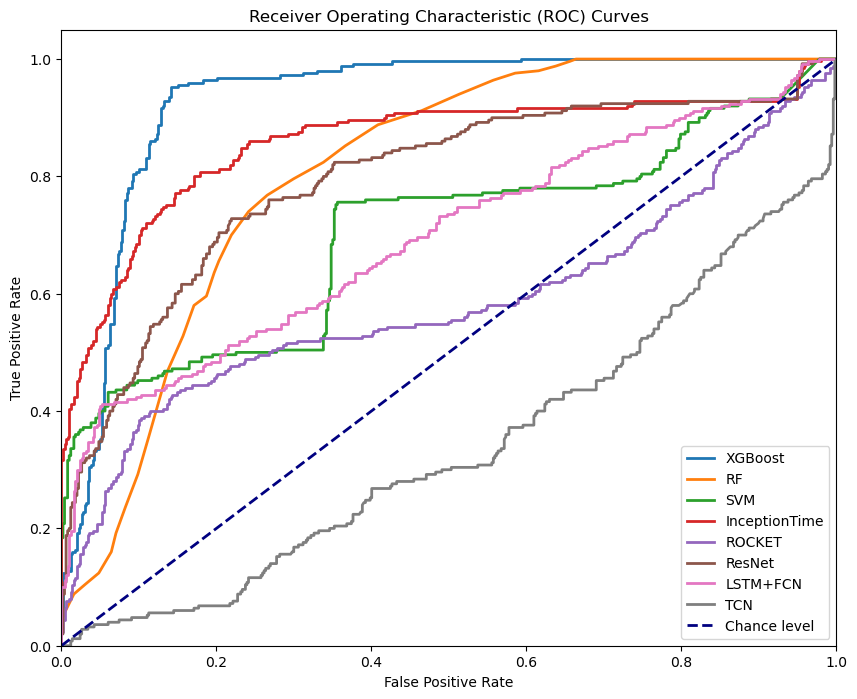

In [32]:
def plot_all_roc_curves(results, y_test):
    plt.figure(figsize=(10, 8))

    for model_name, metrics in results.items():
        y_pred_proba = metrics['Y Proba']
        
        # Calculate FPR, TPR, and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Update results dictionary with ROC AUC, FPR, TPR
        results[model_name].update({'ROC_AUC': roc_auc, 'fpr': fpr, 'tpr': tpr})

        plt.plot(fpr, tpr, lw=2, label=f'{model_name}') #(AUC = {roc_auc:.2f})

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

plot_all_roc_curves(results, y_test)

In [33]:
results_dict = {
    'Model': [],
    'ROC_AUC': [],
    'fpr': [],
    'tpr': [],
    'Accuracy': [],
    'Training Time (s)': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Log_Loss': [],
    'MCC': []
}

# Populate the dictionary with data from the results
for model, metrics in results.items():
    results_dict['Model'].append(model)
    results_dict['ROC_AUC'].append(metrics['ROC_AUC'])
    results_dict['fpr'].append(metrics['fpr'])
    results_dict['tpr'].append(metrics['tpr'])
    results_dict['Accuracy'].append(metrics['Accuracy'])
    results_dict['Training Time (s)'].append(metrics['Training Time (s)'])
    results_dict['Precision'].append(metrics['Precision'])
    results_dict['Recall'].append(metrics['Recall'])
    results_dict['F1 Score'].append(metrics['F1 Score'])
    results_dict['Log_Loss'].append(metrics.get('Log Loss', 'N/A'))
    results_dict['MCC'].append(metrics['MCC'])


# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Save the DataFrame to a CSV file
csv_file_path = ''  
results_df.to_csv(csv_file_path, index=False)

print(f'Results saved to {csv_file_path}')

Results saved to /Users/6u0/Desktop/Research/fault-data-analysis/results/holdout_results.csv


### Plots

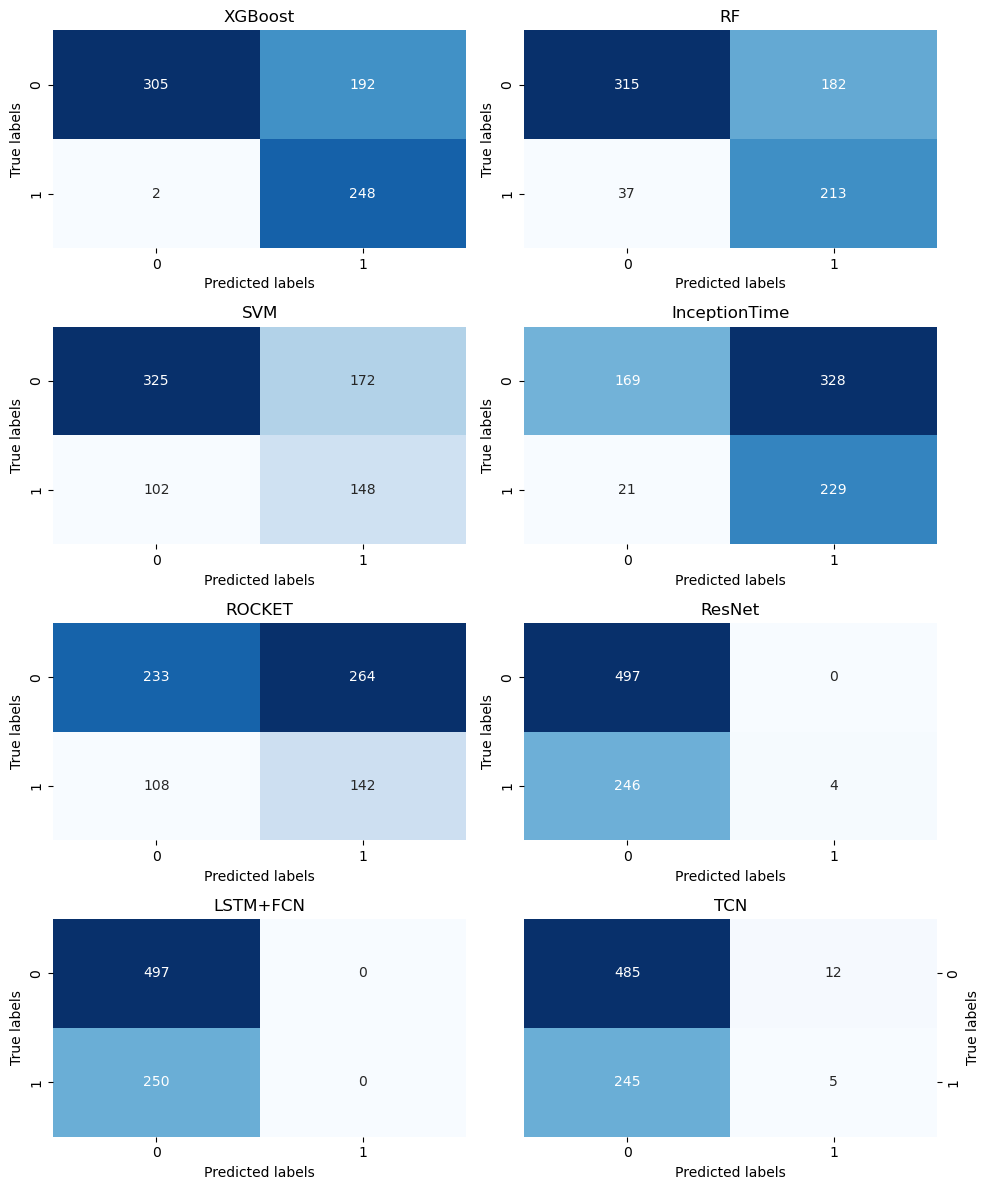

In [34]:
# confusion matrices

method_names = list(results.keys())

# Number of rows and columns for subplots
n_rows = int(np.ceil(len(method_names) / 2))
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3))

if axes.ndim == 1:  # This is for handling cases where there's only one row
    axes = np.expand_dims(axes, axis=0)

for i, method in enumerate(method_names):
    # Retrieve predictions
    y_pred_raw = results[method]['Prediction']
    
    # Convert probabilities to class labels if necessary
    y_pred = np.argmax(y_pred_raw, axis=1) if y_pred_raw.ndim > 1 else y_pred_raw
    
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[i // n_cols, i % n_cols]
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=i == 0,  # Only add cbar to first subplot
                cbar_ax=None if i else fig.axes[-1], ax=ax)
    ax.set_title(method)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

# Adjust layout
plt.tight_layout()

# Hide any unused axes in case of an odd number of methods
if len(method_names) % 2 != 0:
    axes[-1, -1].axis('off')

    
plt.show()

In [35]:
for i, method in enumerate(method_names):
    # Retrieve predictions
    y_pred_raw = results[method]['Prediction']
    
    # Convert probabilities to class labels if necessary
    y_pred = np.argmax(y_pred_raw, axis=1) if y_pred_raw.ndim > 1 else y_pred_raw
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

[[305 192]
 [  2 248]]
[[315 182]
 [ 37 213]]
[[325 172]
 [102 148]]
[[169 328]
 [ 21 229]]
[[233 264]
 [108 142]]
[[497   0]
 [246   4]]
[[497   0]
 [250   0]]
[[485  12]
 [245   5]]


In [40]:
# plotting parameters
SMALL_SIZE = 10
MEDIUM_SIZE = 17
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=17)             # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)   # fontsize of the figure title

In [41]:
def plot_results_acc_auc_grouped(results_df, results, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(17, 7))
    
    for model_name, metrics in results.items():
        y_pred_proba = metrics['Y Proba']
        
        # Calculate FPR, TPR, and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Update results dictionary with ROC AUC, FPR, TPR
        results[model_name].update({'ROC_AUC': roc_auc, 'fpr': fpr, 'tpr': tpr})

        axes[0].plot(fpr, tpr, lw=2, label=f'{model_name}')  #(AUC = {roc_auc:.2f})

    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    #axes[0].set_title('Receiver Operating Characteristic (ROC) Curves')
    axes[0].legend(loc="lower right")
    axes[0].legend(loc="lower right", fontsize=10)
    
    palette = {'XGBoost': 'red', 'RF': 'red', 'SVM': 'red',
               'InceptionTime': 'blue', 'ROCKET': 'blue', 'ResNet': 'blue', 'LSTM+FCN': 'blue', 'TCN': 'blue'}
    markers = {'XGBoost': 'o', 'RF': 's', 'SVM': 'D',
               'InceptionTime': '^', 'ROCKET': 'p', 'ResNet': 'h', 'LSTM+FCN': '*', 'TCN': 'X'}
    
    sns.scatterplot(ax=axes[1], data=results_df, x='Training Time (s)', y='ROC_AUC', hue='Model', style='Model', palette=palette, markers=markers, s=100)
    #axes[1].set_title('AUC vs. Training Time')
    axes[1].set_ylabel('AUC-ROC')
    
    # Remove individual legends to avoid duplication
    axes[1].get_legend().remove()
    
    # Horizontal legend
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, 1.07), fancybox=True, ncol=8)
    
    plt.tight_layout()
    plt.show()

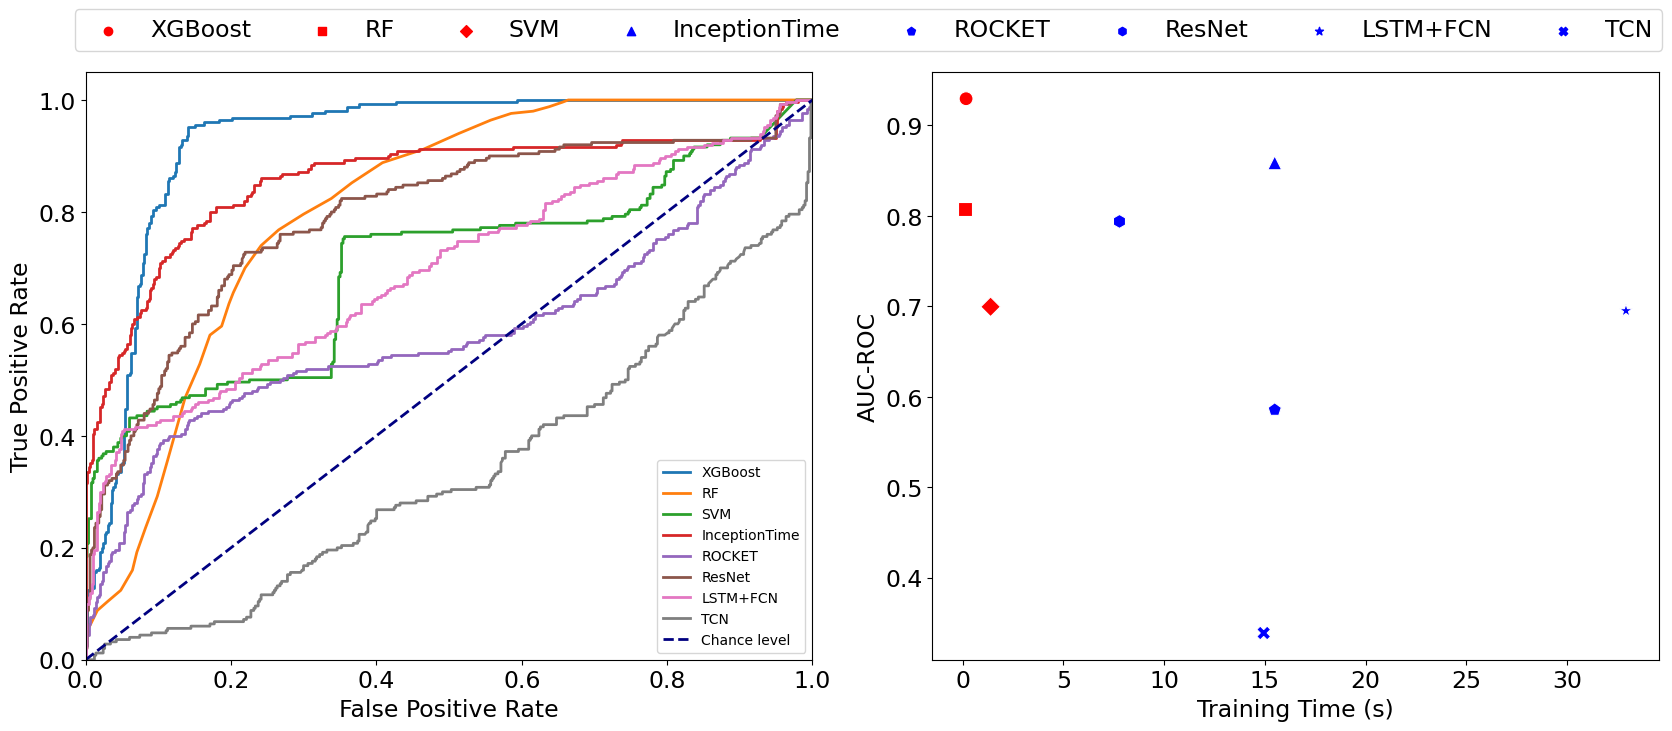

In [42]:
plot_results_acc_auc_grouped(results_df, results, y_test)